In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
import pandas as pd

df=pd.read_csv('gdrive/MyDrive/Colab Notebooks/datasets/healthcare-dataset-stroke-data.csv')
df.info(verbose=True)

################################################################################
# OBSERVATION:
# - BMI has 201 null values
################################################################################

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [3]:
df.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


In [4]:
df_ = df.select_dtypes(exclude=['int', 'float'])
for col in df_.columns:
    print(df_[col].unique())
    print(df_[col].value_counts())
    print('*************************************')

['Male' 'Female' 'Other']
gender
Female    2994
Male      2115
Other        1
Name: count, dtype: int64
*************************************
['Yes' 'No']
ever_married
Yes    3353
No     1757
Name: count, dtype: int64
*************************************
['Private' 'Self-employed' 'Govt_job' 'children' 'Never_worked']
work_type
Private          2925
Self-employed     819
children          687
Govt_job          657
Never_worked       22
Name: count, dtype: int64
*************************************
['Urban' 'Rural']
Residence_type
Urban    2596
Rural    2514
Name: count, dtype: int64
*************************************
['formerly smoked' 'never smoked' 'smokes' 'Unknown']
smoking_status
never smoked       1892
Unknown            1544
formerly smoked     885
smokes              789
Name: count, dtype: int64
*************************************


# Exploratory Data Analysis

**Continuous Data Analysis**

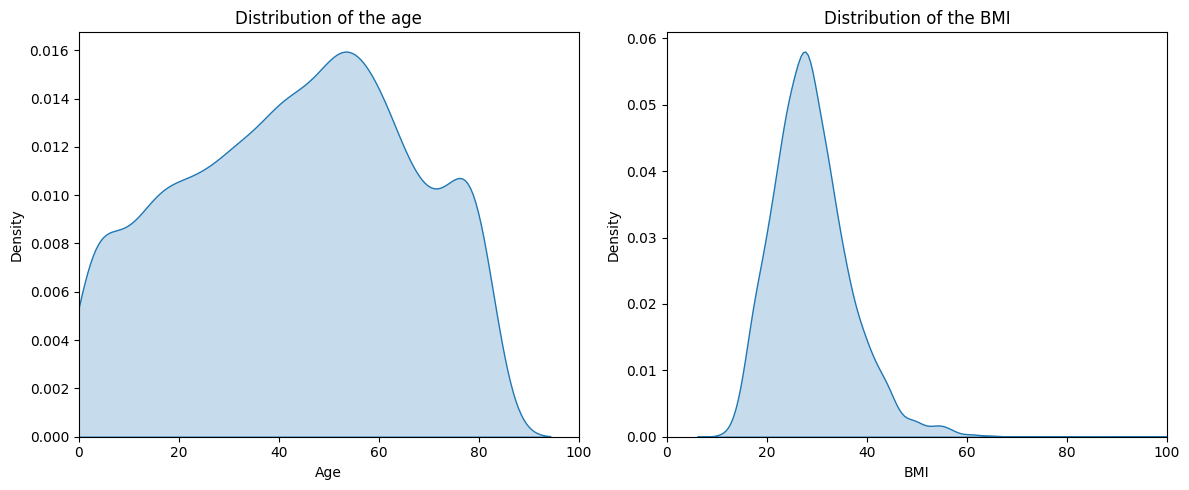

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

sns.kdeplot(df['age'], fill=True, ax=axs[0])
axs[0].set_xlim(0, 100)
axs[0].set_xlabel('Age')
axs[0].set_ylabel('Density')
axs[0].set_title('Distribution of the age')

sns.kdeplot(df['bmi'], fill=True, ax=axs[1])
axs[1].set_xlim(0, 100)
axs[1].set_xlabel('BMI')
axs[1].set_ylabel('Density')
axs[1].set_title('Distribution of the BMI')

plt.tight_layout()
plt.show()

**Discrete Data Analysis**

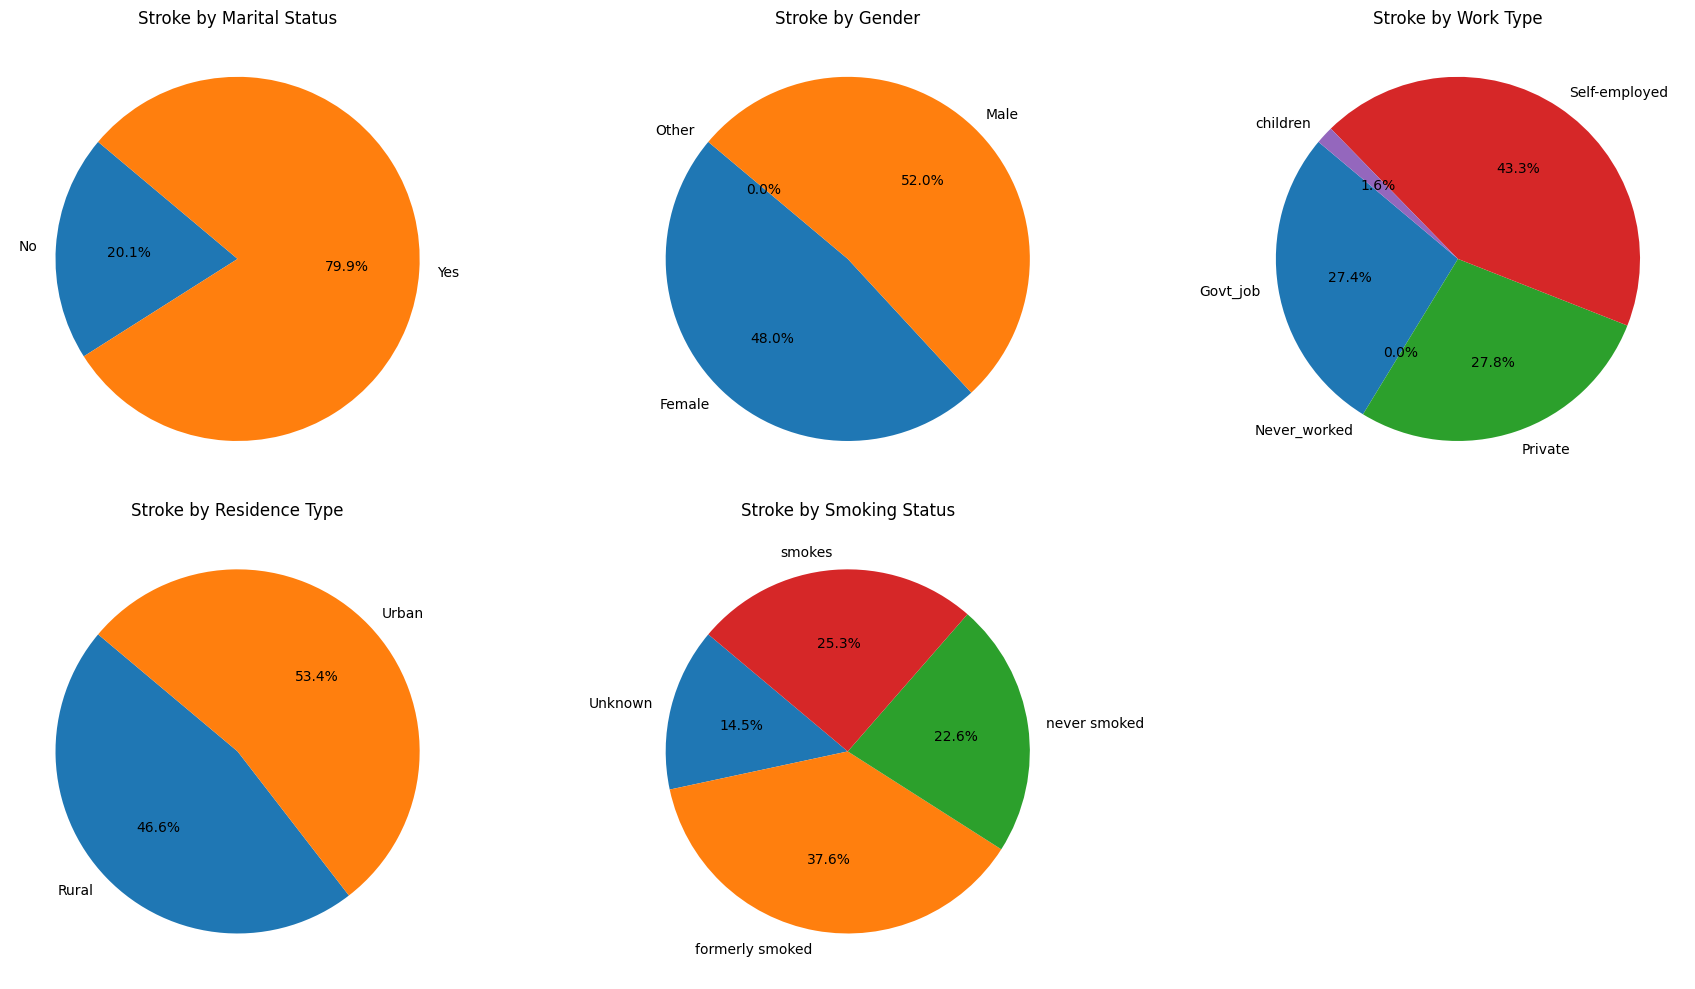

In [6]:
categories = [
    ('ever_married', 'Stroke by Marital Status'),
    ('gender', 'Stroke by Gender'),
    ('work_type', 'Stroke by Work Type'),
    ('Residence_type', 'Stroke by Residence Type'),
    ('smoking_status', 'Stroke by Smoking Status')
]

fig, axs = plt.subplots(2, 3, figsize=(18, 10))

for ax, (cat, title) in zip(axs.flatten(), categories):
    # Calculate stroke rates
    stroke_counts = df.groupby(cat)['stroke'].mean()
    labels = stroke_counts.index
    sizes = stroke_counts.values

    # Plot pie chart
    ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
    ax.set_title(title)

fig.delaxes(axs[1, 2])
plt.tight_layout()
plt.show()

################################################################################
# OBSERVATION:
# - Marital status, work type, and smoking habits are notable factors associated with stroke rates.
# - Married, self-employed, and formerly smoking individuals show higher stroke rates in their respective categories.
################################################################################

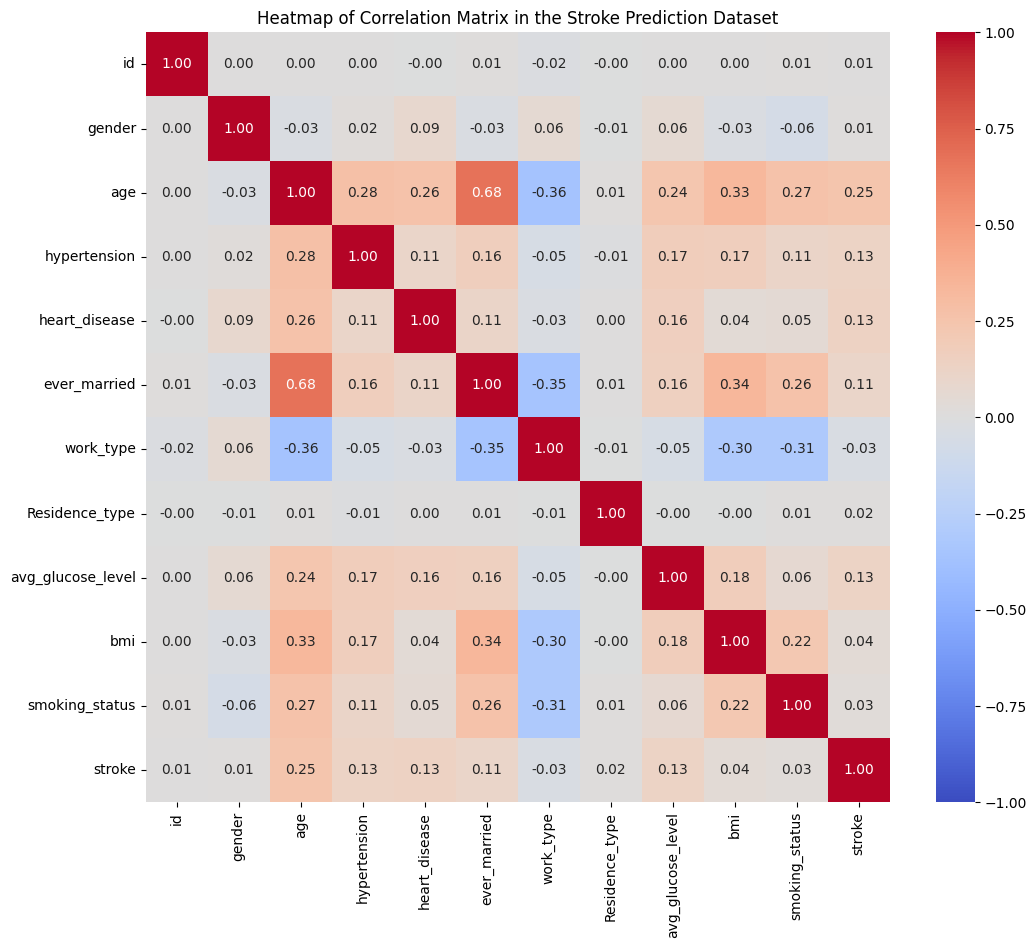

In [7]:
#### Encode categorical data
from sklearn.preprocessing import LabelEncoder

df_copy = df.copy(deep=True)

label_encoder = LabelEncoder()
df_copy['gender'] = label_encoder.fit_transform(df['gender'])
df_copy['ever_married'] = label_encoder.fit_transform(df['ever_married'])
df_copy['work_type'] = label_encoder.fit_transform(df['work_type'])
df_copy['Residence_type'] = label_encoder.fit_transform(df['Residence_type'])
df_copy['smoking_status'] = label_encoder.fit_transform(df['smoking_status'])

#### draw heat map to analyze data correlation
corr_matrix = df_copy.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1)

plt.title('Heatmap of Correlation Matrix in the Stroke Prediction Dataset')
plt.show()

################################################################################
# OBSERVATION:
# - Age, hypertension, heart disease, and average glucose levels appear to be more strongly associated with stroke incidence.
# - Marital status shows some indirect association likely due to its relationship with age.
# - The correlation values are not very high, indicating these factors are not the sole predictors and should be considered alongside other factors in a comprehensive risk assessment.
################################################################################

# Data Preprocessing

**Impute missing BMI values**

In [8]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='median')

df[['bmi']] = imputer.fit_transform(df[['bmi']])

print(df['bmi'].isna().sum())

0


# Feature Selection

**Selecting categorical features using chi-squared test of independence**

In [9]:
from sklearn.feature_selection import chi2

#### Separating features and target variable
all_features = df.drop('stroke', axis=1)
categorical_features = all_features.select_dtypes(exclude=['int64', 'float64'])
y = df['stroke']

categorical_features['gender'] = label_encoder.fit_transform(df['gender'])
categorical_features['ever_married'] = label_encoder.fit_transform(df['ever_married'])
categorical_features['work_type'] = label_encoder.fit_transform(df['work_type'])
categorical_features['Residence_type'] = label_encoder.fit_transform(df['Residence_type'])
categorical_features['smoking_status'] = label_encoder.fit_transform(df['smoking_status'])

chi2_values, p_values = chi2(categorical_features, y)

chi2_df = pd.DataFrame({
    'Feature': categorical_features.columns,
    'Chi2 Stat': chi2_values,
    'p-value': p_values
}).sort_values(by='p-value', ascending=True)

chi2_df

,Feature,Chi2 Stat,p-value
1,ever_married,20.622787,0.000006
4,smoking_status,3.369423,0.066417
2,work_type,2.925901,0.087169
3,Residence_type,0.600717,0.438305
0,gender,0.239001,0.624929


**Selecting numerical features using ANOVA test**

In [10]:
from sklearn.feature_selection import f_classif

#### Separating features and target variable
all_features = df.drop('stroke', axis=1)
numerical_features = all_features.select_dtypes(include=['int64', 'float64'])
y = df['stroke']

F_values, p_values = f_classif(numerical_features, y)
anova_df = pd.DataFrame({
    'Feature': numerical_features.columns,
    'F-Value': F_values,
    'p-Value': p_values
}).sort_values(by='p-Value', ascending=True)

anova_df

,Feature,F-Value,p-Value
1,age,326.916568,7.030778e-71
3,heart_disease,94.698406,3.451927e-22
4,avg_glucose_level,90.503870,2.767811e-21
2,hypertension,84.953542,4.367557e-20
5,bmi,6.669168,9.837071e-03
0,id,0.208459,6.479970e-01


**Observation**

Based on the analysis above, the following features are considered for selection:

* Categorical Features (Chi-Square):
  - ever_married (strong association)
  - smoking_status (domain knowledge)
* Continuous Features (ANOVA):
  - age (very strong association)
  - heart_disease (strong association)
  - avg_glucose_level (strong association)
  - hypertension (strong association)
  - bmi (significant association)

work_type, Residence_type, gender, and id, do not show significant statistical relationships and were excluded.

*NOTE: Low p-value indicates strong influence on the target variable.*

In [11]:
X = df[['ever_married', 'smoking_status', 'age', 'heart_disease', 'avg_glucose_level', 'hypertension', 'bmi']]
y = df['stroke']

# Data Scaling and Encoding

In [12]:
X['ever_married'] = label_encoder.fit_transform(df['ever_married'])
X['smoking_status'] = label_encoder.fit_transform(df['smoking_status'])

<ipython-input-12-3e75fb7530c7>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['ever_married'] = label_encoder.fit_transform(df['ever_married'])
<ipython-input-12-3e75fb7530c7>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['smoking_status'] = label_encoder.fit_transform(df['smoking_status'])


In [13]:
from sklearn.preprocessing import StandardScaler
from sklearn import model_selection

scaler = StandardScaler()
scaler.fit(X)
X_std = scaler.transform(X)

X_train, X_test, y_train, y_test = model_selection.train_test_split(X_std, y, test_size=0.3, random_state=1, stratify=y)

# Model Building

**Neural Network**

In [33]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import accuracy_score
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV

def create_model(optimizer='adam', activation='relu'):
    model = Sequential()
    model.add(Dense(16, input_dim=X_train.shape[1], activation=activation))
    model.add(Dense(8, activation=activation))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

model = KerasClassifier(build_fn=create_model, verbose=0)

param_grid = {
    'batch_size': [10, 20],
    'epochs': [50, 100],
    'model__optimizer': ['adam', 'rmsprop'],
    'model__activation': ['relu', 'sigmoid']
}

# Set up GridSearchCV
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X_train, y_train)

# Best params
best_params = grid.best_params_
best_nn = grid.best_estimator_

print(f"Best Parameters: {best_params}")

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model inst

Best Parameters: {'batch_size': 20, 'epochs': 100, 'model__activation': 'relu', 'model__optimizer': 'adam'}


**Random Forest**

In [32]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [None, 10, 20, 30],
    'criterion': ['gini', 'entropy']
}

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_rf = grid_search.best_estimator_

print(f"Best Parameters: {best_params}")

Fitting 3 folds for each of 48 candidates, totalling 144 fits


/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best Parameters: {'criterion': 'entropy', 'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 100}


**Gradient Boost**

In [31]:
from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier()

param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(estimator=gb, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_gb = grid_search.best_estimator_

print(f"Best Parameters: {best_params}")

Fitting 3 folds for each of 81 candidates, totalling 243 fits
Best Parameters: {'learning_rate': 0.01, 'max_depth': 3, 'min_samples_split': 2, 'n_estimators': 50}


# Model Performance Evaluation

In [42]:
from sklearn.metrics import classification_report

### Neural Network
y_pred = best_nn.predict(X_test)
report = classification_report(y_test, y_pred, target_names=['No Stroke', 'Stroke'])
print('Report: Neural Network')
print(report)

### Random Forest
y_pred = best_rf.predict(X_test)
report = classification_report(y_test, y_pred, target_names=['No Stroke', 'Stroke'])
print('Report: Random Forest')
print(report)

### Gradient Boost
y_pred = best_gb.predict(X_test)
report = classification_report(y_test, y_pred, target_names=['No Stroke', 'Stroke'])
print('Report: Gradient Descent')
print(report)

Report: Neural Network
              precision    recall  f1-score   support

   No Stroke       0.95      1.00      0.97      1458
      Stroke       0.00      0.00      0.00        75

    accuracy                           0.95      1533
   macro avg       0.48      0.50      0.49      1533
weighted avg       0.90      0.95      0.92      1533

Report: Random Forest
              precision    recall  f1-score   support

   No Stroke       0.95      1.00      0.97      1458
      Stroke       0.00      0.00      0.00        75

    accuracy                           0.95      1533
   macro avg       0.48      0.50      0.49      1533
weighted avg       0.90      0.95      0.93      1533

Report: Gradient Descent
              precision    recall  f1-score   support

   No Stroke       0.95      1.00      0.97      1458
      Stroke       0.00      0.00      0.00        75

    accuracy                           0.95      1533
   macro avg       0.48      0.50      0.49      1533
weig

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
